# Proyecto de OCR

## Importación de Librerias y dataset a utilizar

In [ ]:
!pip install tensorflow

In [ ]:
#Importo librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import cv2
import random
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow
from IPython.display import Image as ImageDisplay
from IPython.core.display import HTML
from io import BytesIO
import base64

In [ ]:
#Importo las librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split # Para dividir los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Convierte imagen en binaria para mostrarla en el dataset
def np_to_base64_img(arr):
    """Convierte un np.array a una imagen embebida en base64"""
    h,w = arr.shape[:2]
    im = Image.fromarray(arr)
    buffer = BytesIO()
    im.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode()
    return f'<img src="data:image/png;base64,{img_str}" width="{w}" height="{h}"/>'

In [ ]:
# prompt: quiero convertir esto en un dataset de pandas /content/drive/MyDrive/tp_integrador/letras/character_font.npz y agregar una columna imagen_base64 con el resultado de aplicarle a la imagen en formato np la funcion np_to_base64_img

# Cargar los datos del archivo npz
data = np.load('/content/drive/MyDrive/tp_integrador/letras/character_font.npz')

# Acceder a los arrays dentro del archivo npz
# Asumiendo que el archivo .npz contiene las imágenes bajo una clave como 'images' y las etiquetas bajo una clave como 'labels'
# Si las claves son diferentes, ajústalas aquí
images = data['images']
labels = data['labels']

# Crear un DataFrame de pandas
df_npz = pd.DataFrame({'image': list(images), 'label': list(labels)})

# Aplicar la función np_to_base64_img a la columna 'image'
df_npz['imagen_base64'] = df_npz['image'].apply(np_to_base64_img)

# Mostrar las primeras filas del nuevo DataFrame
print(df_npz.head())

                                               image  label  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      4   

                                       imagen_base64  
0  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
1  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
2  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
3  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
4  <img src="data:image/png;base64,iVBORw0KGgoAAA...  


In [ ]:
# prompt: quiero remplazar los labels de df_npz por la letra en el orden correspondiente del alfabeto

import string

# Crear un mapeo de números a letras del abecedario
num_to_letter = {i: char for i, char in enumerate(string.ascii_uppercase)}

# Reemplazar las etiquetas numéricas por letras
df_npz['label'] = df_npz['label'].apply(lambda x: num_to_letter.get(x, x))

# Mostrar las primeras filas del DataFrame con las etiquetas reemplazadas
print(df_npz.head())


                                               image label  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     A   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     B   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     E   

                                       imagen_base64  
0  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
1  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
2  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
3  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
4  <img src="data:image/png;base64,iVBORw0KGgoAAA...  


,imagen_base64,label
344937,,W
91887,,D
187859,,J
169554,,I
165826,,Y
125052,,S
40783,,P
351374,,L
56797,,N
310014,,R

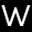
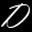
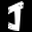
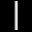
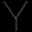
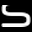
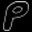
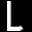
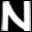
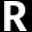
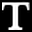
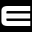
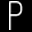
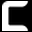
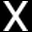
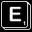
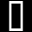
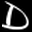
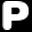
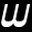

In [ ]:
HTML(df_npz[['imagen_base64','label']].sample(20).to_html(escape=False))

In [ ]:
df_npz.to_csv('/content/drive/MyDrive/tp_integrador/letras/character.csv', index=False)

In [ ]:
# Ruta a la carpeta principal que contiene los subdirectorios
base_dir = '/content/drive/MyDrive/tp_integrador/numeros'

# Lista para almacenar los datos del nuevo dataset
data_list = []

# Recorrer los subdirectorios
for subdir in os.listdir(base_dir):
  subdir_path = os.path.join(base_dir, subdir)

  # Asegurarse de que sea un directorio
  if os.path.isdir(subdir_path):
    label = subdir  # El nombre del subdirectorio es la etiqueta

    # Recorrer los archivos de imagen dentro del subdirectorio
    for filename in os.listdir(subdir_path):
      file_path = os.path.join(subdir_path, filename)

      # Asegurarse de que sea un archivo y sea una imagen (puedes añadir más extensiones si es necesario)
      if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        try:
          # Leer la imagen en escala de grises
          img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
          img = 255 - img
          img = cv2.resize(img, (32, 32))

          if img is not None:
            # Convertir la imagen a base64
            image_base64 = np_to_base64_img(img)

            # Agregar los datos a la lista
            data_list.append({'image': img, 'label': label, 'imagen_base64': image_base64})
          else:
            print(f"Warning: Could not read image file: {file_path}")

        except Exception as e:
          print(f"Error processing file {file_path}: {e}")

# Crear un DataFrame con los datos de los números
df_numeros = pd.DataFrame(data_list)

# Unir el nuevo DataFrame con el DataFrame existente df_npz
df_combined = pd.concat([df_npz, df_numeros], ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print("\nDataFrame combinado:")
print(df_combined.head())

# Puedes mostrar información general sobre el DataFrame combinado
print("\nInformación del DataFrame combinado:")
df_combined.info()


DataFrame combinado:
                                               image label  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     A   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     B   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     C   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     D   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     E   

                                       imagen_base64  
0  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
1  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
2  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
3  <img src="data:image/png;base64,iVBORw0KGgoAAA...  
4  <img src="data:image/png;base64,iVBORw0KGgoAAA...  

Información del DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399925 entries, 0 to 399924
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   image          399925 non-null  ob

In [ ]:
df_numeros.to_csv('/content/drive/MyDrive/tp_integrador/numeros/numeros.csv', index=False)

In [ ]:
df_combined.to_csv('/content/drive/MyDrive/tp_integrador/combined.csv', index=False)

In [ ]:
#Leo el dataset por si vuelvo a ejecutar para arrancar desde aca
df_combined = pd.read_csv('/content/drive/MyDrive/tp_integrador/combined.csv')

,imagen_base64,label
109089,,T
353317,,E
242764,,C
140243,,Z
76718,,S
379281,,U
64329,,F
285168,,A
277158,,Y
175692,,K

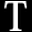
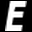
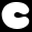
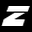
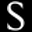
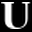
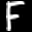
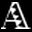
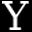
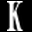
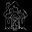
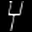
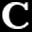
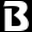
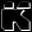
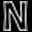
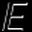
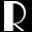
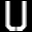
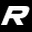
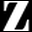
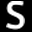
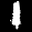
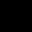
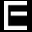
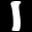
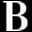
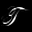
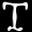
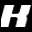

In [ ]:
HTML(df_combined[['imagen_base64','label']].sample(30).to_html(escape=False))

In [ ]:
df_combined.to_csv('/content/drive/MyDrive/tp_integrador/combined.csv', sep=';', index=False)

## Funciones de alteracion de imagenes para el entrenamiento

In [ ]:
#Funciones de ruido
# Ruido de Sal
def add_salt_and_pepper_noise(image, prob):
    """Agrega ruido de sal y pimienta a una imagen PIL."""
    img_array = np.array(image)
    output = np.copy(img_array)
    black = 0
    white = 255
    height, width, channels = img_array.shape if len(img_array.shape) == 3 else (img_array.shape[0], img_array.shape[1], 1)

    for i in range(height):
        for j in range(width):
            if random.random() < prob:
                if random.random() < 0.5:
                    output[i][j] = black
                else:
                    output[i][j] = white
    return output

# Desenfoque
def add_gaussian_blur(imagen_gris_cv2, radius):
    """Aplica desenfoque gaussiano a una imagen CV2 en escala de grises."""
    # cv2.GaussianBlur espera un tamaño de kernel impar y positivo
    # Asegurarse de que el tamaño del kernel sea impar y al menos 1
    kernel_size = int(radius * 2) + 1
    if kernel_size % 2 == 0: # Si es par, hacerlo impar
        kernel_size += 1
    kernel_size = max(1, kernel_size) # Asegurarse de que sea al menos 1
    return cv2.GaussianBlur(imagen_gris_cv2, (kernel_size, kernel_size), 0)

def add_motion_blur(imagen_gris_cv2, radius, angle):
    """Aplica desenfoque de movimiento a una imagen CV2 en escala de grises."""
    longitud = int(radius)
    if longitud == 0:
        return imagen_gris_cv2

    kernel = np.zeros((longitud, longitud), dtype=np.float32)
    center = longitud // 2
    # Crear una línea horizontal para simular el movimiento
    cv2.line(kernel, (0, center), (longitud - 1, center), 1, 1)

    # Rotar el kernel
    M = cv2.getRotationMatrix2D((center, center), angle, 1.0)
    kernel = cv2.warpAffine(kernel, M, (longitud, longitud), flags=cv2.INTER_LINEAR)
    kernel = kernel / (np.sum(kernel) + 1e-6) # Normalizar y evitar división por cero

    output = cv2.filter2D(imagen_gris_cv2, -1, kernel)
    return output

In [ ]:
#Funciones de rotacion, escala y perspectiva

#Funcion de rotacion
def rotar_imagen(imagen, angulo_rotacion_min, angulo_rotacion_max):
    img = Image.fromarray(imagen)
    # Aplico una rotación aleatoria dentro del rango permitido
    angulos_rotacion = [0, 0, random.uniform(-angulo_rotacion_max, angulo_rotacion_max)]
    angulo_rotacion = random.choice(angulos_rotacion)
    imagen_rotada = img.rotate(angulo_rotacion, resample=Image.Resampling.BILINEAR, expand=True)
    imagen = np.array(imagen_rotada)
    return imagen

# Perspectiva Vertical
def aplicar_perspectiva_vertical(imagen, factor, top=True):
    """
    Aplica una transformación de perspectiva vertical a una imagen.

    Args:
        imagen (np.ndarray): La imagen de entrada en formato numpy array (BGR o escala de grises).
        factor (float): Factor de escala para reducir la distancia de las esquinas (entre 0 y 1).
        top (bool): Si es True, aplica la perspectiva a las esquinas superiores.
                    Si es False, aplica la perspectiva a las esquinas inferiores.

    Returns:
        np.ndarray: La imagen con la perspectiva aplicada.
    """
    height, width = imagen.shape[:2]

    # Puntos originales (esquinas de la imagen)
    pts1 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    # Puntos de destino después de la transformación
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    if 0 <= factor <= 1:
        if top:
            # Reduce la distancia entre las dos esquinas superiores
            new_top_left_x = int(width * (1 - factor) / 2)
            new_top_right_x = width - 1 - new_top_left_x

            pts2[0] = [new_top_left_x, 0]
            pts2[1] = [new_top_right_x, 0]
        else:
            # Reduce la distancia entre las dos esquinas inferiores
            new_bottom_left_x = int(width * (1 - factor) / 2)
            new_bottom_right_x = width - 1 - new_bottom_left_x

            pts2[2] = [new_bottom_right_x, height - 1]
            pts2[3] = [new_bottom_left_x, height - 1]
    else:
        print("Advertencia: El factor de perspectiva debe estar entre 0 y 1. No se aplicó la transformación.")
        return imagen


    # Obtener la matriz de transformación de perspectiva
    M = cv2.getPerspectiveTransform(pts1, pts2)

    # Aplicar la transformación de perspectiva
    imagen_con_perspectiva = cv2.warpPerspective(imagen, M, (width, height))

    return imagen_con_perspectiva

# Perspectiva horizontal
def aplicar_perspectiva_horizontal(imagen, factor, left=True):
    """
    Aplica una transformación de perspectiva horizontal a una imagen.

    Args:
        imagen (np.ndarray): La imagen de entrada en formato numpy array (BGR o escala de grises).
        factor (float): Factor de escala para reducir la distancia de las esquinas (entre 0 y 1).
        left (bool): Si es True, aplica la perspectiva a las esquinas izquierdas.
                     Si es False, aplica la perspectiva a las esquinas derechas.

    Returns:
        np.ndarray: La imagen con la perspectiva aplicada.
    """
    height, width = imagen.shape[:2]

    # Puntos originales (esquinas de la imagen)
    pts1 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    # Puntos de destino después de la transformación
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

    if 0 <= factor <= 1:
        if left:
            # Reduce la distancia entre las dos esquinas izquierdas
            new_top_left_y = int(height * (1 - factor) / 2)
            new_bottom_left_y = height - 1 - new_top_left_y

            pts2[0] = [0, new_top_left_y]
            pts2[3] = [0, new_bottom_left_y]
        else:
            # Reduce la distancia entre las dos esquinas derechas
            new_top_right_y = int(height * (1 - factor) / 2)
            new_bottom_right_y = height - 1 - new_top_right_y

            pts2[1] = [width - 1, new_top_right_y]
            pts2[2] = [width - 1, new_bottom_right_y]
    else:
        print("Advertencia: El factor de perspectiva debe estar entre 0 y 1. No se aplicó la transformación.")
        return imagen


    # Obtener la matriz de transformación de perspectiva
    M = cv2.getPerspectiveTransform(pts1, pts2)

    # Aplicar la transformación de perspectiva
    imagen_con_perspectiva = cv2.warpPerspective(imagen, M, (width, height))

    return imagen_con_perspectiva

# Re escalado de Imagen
def reescalar_imagen(imagen_gris_cv2, factor, aumento):
    """Reescala una imagen CV2 en escala de grises.

    Args:
        imagen_gris_cv2 (np.ndarray): La imagen de entrada en formato numpy array (escala de grises).
        factor (float): El factor base de escalado.
        aumento (bool): Si es True, el factor de escala será entre 1.0 y 'factor'.
                        Si es False, el factor de escala será entre 1/factor y 1.0.

    Returns:
        np.ndarray: La imagen reescalada en escala de grises.
    """
    if aumento:
        scale_factor = random.uniform(1.0, factor)
    else:
        scale_factor = random.uniform(1/factor, 1.0)

    new_w = int(imagen_gris_cv2.shape[1] * scale_factor)
    new_h = int(imagen_gris_cv2.shape[0] * scale_factor)

    # Asegurarse de que el nuevo tamaño no sea cero
    new_w = max(1, new_w)
    new_h = max(1, new_h)

    resized_imagen = cv2.resize(imagen_gris_cv2, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return resized_imagen


In [ ]:
# Funciones de variacion del color
def ajustar_brillo(imagen_gris_cv2, valor_brillo):
    """Ajusta el brillo de una imagen CV2 en escala de grises."""
    # Usando np.clip con operaciones aritméticas directas de NumPy para mayor robustez.
    return np.clip(imagen_gris_cv2.astype(np.int16) + valor_brillo, 0, 255).astype(np.uint8)

def ajustar_contraste(imagen_gris, factor_contraste):
    # Asegura que el factor de contraste sea positivo
    factor_clipeado = max(0.0, factor_contraste)

    # Aplica el ajuste de contraste
    # Convertir a float para evitar problemas con la multiplicación y luego a uint8
    imagen_float = imagen_gris.astype(np.float32)

    # Fórmula: alpha * pixel_value + beta (donde beta = 128 * (1 - alpha) para mantener el punto medio)
    # Sin embargo, la forma más directa es como la fórmula mencionada: alpha * (P - medio) + medio
    # OpenCV's convertScaleAbs hace (alpha * src + beta)
    # Para la fórmula de contraste que dimos, beta sería: 128 * (1 - factor_contraste)

    imagen_ajustada = cv2.convertScaleAbs(imagen_float, alpha=factor_clipeado, beta=128 * (1 - factor_clipeado))

    return imagen_ajustada

In [ ]:
def aplicar_transformacion_aleatoria(imagen_cv2):
    """
    Decide si aplicar transformaciones (50% de probabilidad) y, si lo hace,
    aplica entre 1 y 3 transformaciones aleatorias.
    Todas las transformaciones reciben y devuelven imágenes CV2 en escala de grises.

    Args:
        imagen_cv2 (np.ndarray): La imagen de entrada en formato numpy array (BGR o escala de grises).

    Returns:
        np.ndarray: La imagen transformada o la original, siempre en escala de grises (CV2).
    """
    # Primero, asegurar que la imagen de entrada esté en escala de grises
    if len(imagen_cv2.shape) == 3:
        imagen_gris_original = cv2.cvtColor(imagen_cv2, cv2.COLOR_BGR2GRAY)
    else:
        imagen_gris_original = imagen_cv2.copy() # Copia para no modificar la original

    # 50% de probabilidad de no aplicar ninguna transformación
    if random.random() < 0.5:
        return imagen_gris_original # Devuelve la imagen original en escala de grises

    # Si llegamos aquí, vamos a aplicar transformaciones
    imagen_actual = imagen_gris_original # Empezamos con la versión gris de la imagen

    # Lista de transformaciones disponibles (TODAS operan en CV2 gris y devuelven CV2 gris)
    transformaciones_disponibles = [
        # Las funciones deben ser las versiones que reciben/devuelven CV2 gris
        {'func': add_salt_and_pepper_noise, 'params': {'prob': random.uniform(0.005, 0.03)}},
        {'func': add_gaussian_blur, 'params': {'radius': random.uniform(0.5, 1.5)}},
        {'func': add_motion_blur, 'params': {'radius': random.randint(5, 15), 'angle': random.uniform(0, 360)}},
        {'func': rotar_imagen, 'params': {'angulo_rotacion_min': -5, 'angulo_rotacion_max': 5}},
        {'func': aplicar_perspectiva_vertical, 'params': {'factor': random.uniform(0.05, 0.2), 'top': random.choice([True, False])}},
        {'func': aplicar_perspectiva_horizontal, 'params': {'factor': random.uniform(0.05, 0.2), 'left': random.choice([True, False])}},
        {'func': reescalar_imagen, 'params': {'factor': random.uniform(0.8, 1.2), 'aumento': random.choice([True, False])}},
        {'func': ajustar_brillo, 'params': {'valor_brillo': random.randint(-30, 30)}},
        {'func': ajustar_contraste, 'params': {'factor_contraste': random.uniform(0.8, 1.2)}},
    ]

    # Elegir entre 1 y 3 transformaciones para aplicar
    num_transformaciones = random.randint(1, 3)
    # Usamos random.sample para elegir funciones únicas si num_transformaciones es menor que la lista completa
    transformaciones_a_aplicar = random.sample(transformaciones_disponibles, num_transformaciones)

    for trans_info in transformaciones_a_aplicar:
        func = trans_info['func']
        params = trans_info['params']

        try:
            # Todas las funciones ahora reciben y devuelven CV2 en escala de grises
            imagen_actual = func(imagen_actual, **params)
        except Exception as e:
            print(f"Error al aplicar la transformación '{func.__name__}': {e}. Se mantiene la imagen actual para la siguiente transformación.")

    return imagen_actual


## Implementacion de la red neuronal

## Variables de ajuste

In [ ]:
# --- Parámetros globales y mapeos de caracteres (reconfirmar si ya los tienes) ---
# Asegúrate de que NUM_CLASES_SALIDA sea 37, como habíamos acordado
NUM_CLASES_SALIDA = 37 # A-Z (26) + 0-9 (10) + 'blank' (1)

# Mapeo de caracteres a índices (0-36)
# El espacio ' ' (blank) va al final, como índice 36
VOCABULARIO = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "
CHAR_TO_INDEX = {char: i for i, char in enumerate(VOCABULARIO)}
INDEX_TO_CHAR = {i: char for i, char in enumerate(VOCABULARIO)}

# --- Tamaño de las imágenes de entrada a la red ---
# Esto es crucial. Todas las imágenes deben tener el mismo tamaño para alimentar la red.
# Si tus imágenes originales tienen tamaños variados, deberás preprocesarlas a este tamaño.
# Ajusta estos valores según el tamaño promedio/deseado de tus imágenes de OCR.
IMAGEN_ANCHO = 32
IMAGEN_ALTO = 32

## Definicion de la Red Neuronal

In [ ]:
# --- Definición de la Red Neuronal (tal cual como antes) ---
def build_ocr_model(input_shape, num_classes):
    """
    Construye el modelo de red neuronal convolucional para OCR
    basado en la descripción provista: [1,36,0,1 Ct5,5,16 Mp3,3 Lfys64 Lfx96 Lrx96 Lbx96 Lbx96 O1c37]
    """
    input_img = keras.Input(shape=input_shape, name="image")

    # [Ct5,5,16] - Capa Convolucional
    x = layers.Conv2D(
        filters=16,
        kernel_size=(5, 5),
        padding="same",
        activation="relu",
        name="conv_1",
    )(input_img)

    # [Mp3,3] - Capa de Max-Pooling
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name="pool_1")(x)

    # Aplanar los mapas de características antes de las capas densas (Fully Connected)
    x = layers.Flatten(name="flatten")(x)

    # [Lfys64] - Capa Fully Connected con 64 neuronas
    x = layers.Dense(64, activation="relu", name="dense_1")(x)

    # [Lfx96] - Capa Fully Connected con 96 neuronas
    x = layers.Dense(96, activation="relu", name="dense_2")(x)

    # [Lrx96] - Capa Fully Connected con 96 neuronas
    x = layers.Dense(96, activation="relu", name="dense_3")(x)

    # [Lbx96] - Capa Fully Connected con 96 neuronas
    x = layers.Dense(96, activation="relu", name="dense_4")(x)

    # [Lbx96] - Otra Capa Fully Connected con 96 neuronas
    x = layers.Dense(96, activation="relu", name="dense_5")(x)

    # [O1c37] - Capa de Salida
    # La capa de salida debe tener `num_classes` (37) neuronas
    # y usar activación softmax para clasificación multiclase.
    output = layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.Model(inputs=input_img, outputs=output, name="ocr_model")
    return model

In [ ]:
# --- Función de preprocesamiento de imágenes ---
def preprocess_image(image_np_array, target_size=(IMAGEN_ANCHO, IMAGEN_ALTO)):
    """
    Normaliza y redimensiona la imagen para la entrada a la red.
    Asume que la imagen_np_array ya está en escala de grises.
    """
    # Asegurarse de que la imagen esté en el formato correcto (ALTO, ANCHO)
    if image_np_array.shape != (target_size[1], target_size[0]): # Nota: target_size es (ancho, alto)
        image_np_array = cv2.resize(image_np_array, target_size, interpolation=cv2.INTER_AREA)

    # Normalizar los píxeles a [0, 1]
    image_normalized = image_np_array.astype(np.float32) / 255.0

    # Keras espera las imágenes con un canal final si son monocromáticas (alto, ancho, 1)
    image_final = np.expand_dims(image_normalized, axis=-1)

    return image_final

# --- Función para codificar etiquetas ---
def encode_labels(label_text, char_to_index_map):
    """
    Codifica un string de etiqueta a un índice numérico.
    """
    if label_text in char_to_index_map:
        return char_to_index_map[label_text]
    else:
        print(f"Advertencia: Caracter '{label_text}' no encontrado en el vocabulario. Mapeando a blank.")
        return char_to_index_map[' '] # Mapea a 'blank'

# --- Función para cargar tu dataset (Ejemplo con un DataFrame) ---
def cargar_dataset_desde_dataframe(df):
    """
    Carga imágenes y etiquetas desde tu DataFrame.
    Esta es una implementación dummy para probar el código.
    """
    dummy_data = []
    # Genera algunas imágenes y etiquetas de prueba (A-Z, 0-9)
    for char_val in VOCABULARIO[:-1]: # Excluir 'blank' para generación de data
        dummy_img = np.zeros((IMAGEN_ALTO, IMAGEN_ANCHO), dtype=np.uint8)
        # Dibujar el caracter en la imagen
        text_size = cv2.getTextSize(char_val, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = (IMAGEN_ANCHO - text_size[0]) // 2
        text_y = (IMAGEN_ALTO + text_size[1]) // 2
        cv2.putText(dummy_img, char_val, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255), 2, cv2.LINE_AA)
        dummy_data.append({'image_np': dummy_img, 'label': char_val})

    # Multiplicar los datos para tener más volumen si es necesario
    dummy_df = pd.DataFrame(dummy_data)
    # Aumentar artificialmente el tamaño para pruebas
    dummy_df = pd.concat([dummy_df] * 50, ignore_index=True)

    print(f"Dataset cargado. Total de {len(dummy_df)} muestras.")
    return dummy_df


# --- Bucle de Entrenamiento por Épocas (Adaptado) ---
def entrenar_modelo_ocr(dataframe_datos, num_epochs=10, batch_size=32, train_split=0.8):

    train_data = dataframe_datos

    # 2. Construir el modelo
    input_shape = (IMAGEN_ALTO, IMAGEN_ANCHO, 1) # (alto, ancho, canales)
    model = build_ocr_model(input_shape, NUM_CLASES_SALIDA)

    # Compilar el modelo
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    print("\nResumen del modelo:")
    model.summary()

    # 3. Bucle de entrenamiento
    print(f"\nComenzando el entrenamiento por {num_epochs} épocas...")
    for epoch in range(num_epochs):
        print(f"\n--- Época {epoch + 1}/{num_epochs} ---")

        # Mezclar el dataframe en cada época para asegurar aleatoriedad
        shuffled_train_data = train_data.sample(frac=1).reset_index(drop=True)

        # Almacenará las imágenes y etiquetas procesadas para la época actual
        epoch_images = []
        epoch_labels = []

        # Procesar todas las imágenes de la época, llamando a aplicar_transformacion_aleatoria
        # Esta función ahora decide internamente si transformar o no, y cuántas transformaciones aplicar
        print(f"Procesando {len(shuffled_train_data)} muestras para la época (con aumento de datos)...")
        for _, row in shuffled_train_data.iterrows():
            img = row['image']
            label = row['label']

            # Aquí llamamos a la función que ahora encapsula toda la lógica de aumento de datos
            transformed_or_original_img = aplicar_transformacion_aleatoria(img)

            # Preprocesar la imagen (ya sea transformada u original)
            processed_img = preprocess_image(transformed_or_original_img, target_size=(IMAGEN_ANCHO, IMAGEN_ALTO))
            encoded_label = encode_labels(label, CHAR_TO_INDEX) # La etiqueta no cambia por las transformaciones visuales

            epoch_images.append(processed_img)
            epoch_labels.append(encoded_label)

        # Convertir a NumPy arrays para el entrenamiento
        X_epoch = np.array(epoch_images)
        y_epoch = np.array(epoch_labels)

        # Mezclar nuevamente el conjunto de datos de la época antes del entrenamiento
        indices = np.arange(len(X_epoch))
        np.random.shuffle(indices)
        X_epoch = X_epoch[indices]
        y_epoch = y_epoch[indices]

        print(f"Entrenando con {len(X_epoch)} muestras para esta época...")

        # Entrenar el modelo con los datos de esta época
        history = model.fit(
            X_epoch,
            y_epoch,
            batch_size=batch_size,
            epochs=1, # Entrenar por 1 época en cada iteración de este bucle
            verbose=1,
        )

    print("\nEntrenamiento completado.")
    return model

In [ ]:
# --- Bloque principal para ejecutar el entrenamiento ---
if __name__ == "__main__":
    # Simular la carga de tu DataFrame
    # REEMPLAZA ESTA LLAMADA con la forma en que cargas tu DataFrame real
    df_entrenamiento = df_combined

    # Ejecutar el entrenamiento
    modelo_entrenado = entrenar_modelo_ocr(
        dataframe_datos=df_entrenamiento,
        num_epochs=30,     # Número de épocas de entrenamiento
        batch_size=64     # Tamaño del lote (batch size)
    )


Resumen del modelo:


Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 32, 32, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 37)             │         3,589 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,645 (549.39 KB)

 Trainable params: 140,645 (549.39 KB)

 Non-trainable params: 0 (0.00 B)


Comenzando el entrenamiento por 30 épocas...

--- Época 1/30 ---
Procesando 399925 muestras para la época (con aumento de datos)...
Entrenando con 399925 muestras para esta época...
6249/6249 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5774 - loss: 1.5520

--- Época 2/30 ---
Procesando 399925 muestras para la época (con aumento de datos)...
Entrenando con 399925 muestras para esta época...
6249/6249 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7131 - loss: 1.0289

--- Época 3/30 ---
Procesando 399925 muestras para la época (con aumento de datos)...
Entrenando con 399925 muestras para esta época...
6249/6249 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7346 - loss: 0.9479

--- Época 4/30 ---
Procesando 399925 muestras para la época (con aumento de datos)...
Entrenando con 399925 muestras para esta época...
6249/6249 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7444 - loss: 0.9134

--- Época 5/30 ---
Procesando 399925 muestras para la época (con aumento de datos)...
Entrena

In [ ]:
nombre_del_modelo = "/content/drive/MyDrive/tp_integrador/ocr_model_final_30_EPOCAS.keras" # Formato recomendado para Keras 3+

# nombre_del_modelo = "ocr_model_final.h5" # Formato HDF5, compatible con Keras 2 y versiones anteriores de TF
modelo_entrenado.save(nombre_del_modelo)
print(f"Modelo guardado exitosamente como '{nombre_del_modelo}'")

Modelo guardado exitosamente como '/content/drive/MyDrive/tp_integrador/ocr_model_final_30_EPOCAS.keras'


## Prueba del Modelo

In [ ]:
model = tf.keras.models.load_model(nombre_del_modelo)
import gradio as gr

# --- Función de preprocesamiento de imágenes (de tu código de entrenamiento) ---
def preprocess_image(image_np_array, target_size=(IMAGEN_ANCHO, IMAGEN_ALTO)):
    """
    Normaliza y redimensiona la imagen para la entrada a la red.
    Asume que la imagen_np_array ya está en escala de grises.
    """
    # Asegurarse de que la imagen esté en el formato correcto (ALTO, ANCHO)
    if image_np_array.shape != (target_size[1], target_size[0]): # Nota: target_size es (ancho, alto)
        image_np_array = cv2.resize(image_np_array, target_size, interpolation=cv2.INTER_AREA)

    # Normalizar los píxeles a [0, 1]
    image_normalized = image_np_array.astype(np.float32) / 255.0

    # Keras espera las imágenes con un canal final si son monocromáticas (alto, ancho, 1)
    image_final = np.expand_dims(image_normalized, axis=-1)

    return image_final

# --- Función principal de inferencia de OCR ---
def run_ocr_inference(input_image):
    """
    Procesa una imagen de entrada para OCR: detecta contornos,
    separa en cajas, analiza cada caja con el modelo y concatena los resultados.

    Args:
        input_image (np.ndarray): La imagen de entrada desde Gradio (puede ser RGB).

    Returns:
        str: El string concatenado de los caracteres reconocidos.
        np.ndarray: La imagen con los contornos y bounding boxes dibujados para visualización.
    """
    if model is None:
        return "Error: El modelo de OCR no se pudo cargar.", input_image

    # Convertir la imagen a escala de grises
    # Gradio suele pasar imágenes como RGB, así que convertimos a BGR para OpenCV
    # y luego a escala de grises.
    if len(input_image.shape) == 3 and input_image.shape[2] == 3:
        gray_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = input_image.copy() # Ya es escala de grises

    # Preparar una copia de la imagen para dibujar los contornos
    display_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR) # Convertir a BGR para dibujar en color

    # Binarizar la imagen (umbralización) para facilitar la detección de contornos
    # Puedes experimentar con diferentes umbrales o métodos de binarización
    # Se mantiene la binarización global para la detección de contornos,
    # pero cada ROI se binarizará individualmente a blanco sobre negro.
    _, binary_for_contours = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Encontrar contornos en la imagen binarizada
    # cv2.RETR_EXTERNAL para solo contornos externos, cv2.CHAIN_APPROX_SIMPLE para puntos simplificados
    contours, _ = cv2.findContours(binary_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_characters = []

    # Almacenar bounding boxes junto con sus coordenadas para ordenar
    boxes = []

    # Iterar sobre cada contorno encontrado
    for contour in contours:
        # Calcular el rectángulo delimitador (bounding box) para cada contorno
        x, y, w, h = cv2.boundingRect(contour)

        # Filtrar contornos muy pequeños o muy grandes que no sean caracteres
        # Estos valores son heurísticos y pueden necesitar ajuste para tu dataset
        min_area = 50 # Área mínima para considerar un contorno como carácter
        min_aspect_ratio = 0.1 # Relación ancho/alto mínima
        max_aspect_ratio = 10 # Relación ancho/alto máxima

        if w * h < min_area:
            continue
        if not (min_aspect_ratio < w/h < max_aspect_ratio):
            continue

        # También puedes filtrar por altura o ancho mínimo/máximo si sabes el rango de tus caracteres
        # if h < 10 or w < 5: continue # Ejemplo: altura mínima 10px, ancho mínimo 5px

        # Guardar la caja con su coordenada X para el ordenamiento
        boxes.append({"box": (x, y, w, h), "x_coord": x})

    # --- Lógica de Ordenamiento Modificada ---
    # Ordenar todas las cajas directamente por su coordenada X para ir de izquierda a derecha.
    # No se agrupa por líneas, lo que cumple con "sin importar la altura".
    if boxes:
        boxes.sort(key=lambda b: b["x_coord"])
        sorted_boxes = boxes # Todas las cajas ya están ordenadas por X
    else:
        sorted_boxes = [] # No hay cajas para procesar

    # Procesar cada caja con el modelo OCR
    for box_info in sorted_boxes:
        x, y, w, h = box_info["box"]

        # Dibujar el bounding box en la imagen para visualización
        cv2.rectangle(display_image, (x, y), (x + w, y + h), (0, 255, 0), 2) # Verde

        # Recortar la región de interés (ROI)
        roi = gray_image[y:y+h, x:x+w]

        # --- Convertir cada BOX a negro y blanco (carácter blanco, fondo negro) ---
        _, roi_binary = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        # -----------------------------------------------------------------------

        # Preprocesar la ROI binarizada para la entrada del modelo
        processed_roi = preprocess_image(roi_binary, target_size=(IMAGEN_ANCHO, IMAGEN_ALTO))

        # Realizar la predicción
        # El modelo espera un batch, así que expandimos las dimensiones: (1, alto, ancho, 1)
        predictions = model.predict(np.expand_dims(processed_roi, axis=0), verbose=0)

        # Obtener el índice de la clase predicha con mayor probabilidad
        predicted_class_index = np.argmax(predictions[0])

        # Convertir el índice a carácter
        predicted_char = INDEX_TO_CHAR.get(predicted_class_index, '?') # Usar '?' para desconocidos

        detected_characters.append(predicted_char)

    # Unir todos los caracteres detectados en un solo string
    result_string = "".join(detected_characters)

    # Convertir la imagen de visualización de BGR a RGB para Gradio
    display_image_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)

    return result_string, display_image_rgb

# --- Configuración de la interfaz Gradio ---
iface = gr.Interface(
    fn=run_ocr_inference,
    inputs=gr.Image(type="numpy", label="Sube una imagen para OCR"),
    outputs=[
        gr.Textbox(label="Texto Reconocido"),
        gr.Image(type="numpy", label="Imagen con Cajas Detectadas")
    ],
    title="OCR Personalizado (A-Z, 0-9)",
    description="Sube una imagen con caracteres (letras mayúsculas y números) para que el modelo los detecte y reconozca."
)

# Lanzar la interfaz
if __name__ == "__main__":
    iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://810e9d4b3d47582a39.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
